In [197]:
print("hello world")

hello world


In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [199]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

print(dfs['weather_data'].head())
dfs['sensor_readings'].head()

      timestamp  Barometric_Pressure   Humidity  Temperature  Wind_Direction  \
0  4/18/23 0:00           827.064433  32.200298    10.971487      306.335774   
1  4/18/23 0:00           827.073897  32.200297    11.116626      311.523873   
2  4/18/23 0:00           827.301068  32.138772    10.861056      324.694315   
3  4/18/23 0:00           827.073913  32.100913    11.012511      316.473451   
4  4/18/23 0:00           827.092847  31.999946    10.969914      315.187093   

   Wind_Speed  
0    1.836502  
1    1.875021  
2    1.966547  
3    2.060548  
4    1.947818  


,Unnamed: 0,time,111111_ 40.595561_-105.14055_3,111111_ 40.596108_-105.140583_4,111111_40.595556_-105.140069_2,111111_40.596114_-105.140075_1,222222_ 40.596108_-105.140583_4,222222_40.595556_-105.140069_2,222222_40.595561_-105.14055_3,222222_40.596114_-105.140075_1,...,444444_40.595881_-105.139686_1,444444_40.595947_-105.139833_4,555555_40.595542_-105.139211_2,555555_40.595547_-105.139714_3,555555_40.596089_-105.139144_1,555555_40.596097_-105.139678_4,666666_40.595542_-105.139211_2,666666_40.595547_-105.139714_3,666666_40.596089_-105.139144_1,666666_40.596097_-105.139678_4
0,1,1681776002,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,...,1120.0,735.0,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0
1,2,1681776003,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,...,1104.5,765.0,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0
2,3,1681776004,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,...,1089.0,762.0,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0
3,4,1681776005,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,...,1082.0,762.0,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0
4,5,1681776006,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,...,1070.0,763.0,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5


Shape of the dataset:  (86401, 6)


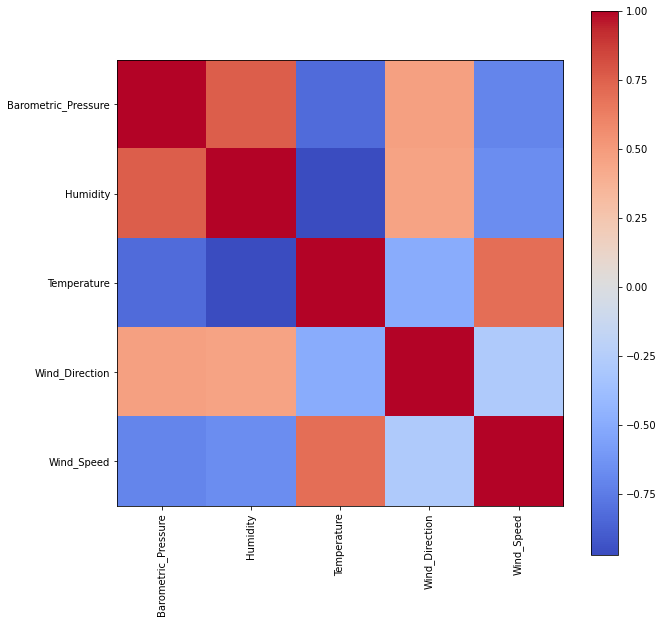

In [200]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)
# Get the correlation of the features
corr = curr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.imshow(corr, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.show()

In [201]:
leak_locations_and_rate.head()

,EventID,NumberSourcesLeaking,LeakPointId,Latitude,Longitude,EmissionCategory,UTCStart,UTCEnd,Duration,LeakRate,BFT,tStart,tEnd
0,40,2,4T-31,40.595830,-105.139824,Fugitive,2023-04-18_00:00:35.000000,2023-04-18_00:15:35.000000,900,36.636270,ReferenceMeteredEvent,1681776035,1681776935
1,40,2,5S-26,40.595924,-105.139390,Fugitive,2023-04-18_00:00:35.000000,2023-04-18_00:15:35.000000,900,64.621765,ReferenceMeteredEvent,1681776035,1681776935
2,41,2,4W-27,40.595936,-105.140270,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_01:00:35.000000,2700,55.385376,ReferenceMeteredEvent,1681776935,1681779635
3,41,2,4S-43,40.595642,-105.140350,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_01:00:35.000000,2700,24.345577,ReferenceMeteredEvent,1681776935,1681779635
4,42,2,4T-31,40.595830,-105.139824,Fugitive,2023-04-18_00:15:35.000000,2023-04-18_00:45:35.000000,1800,36.636270,ReferenceMeteredEvent,1681776935,1681778735


In [202]:
sensor_readings.head()

,Unnamed: 0,time,111111_ 40.595561_-105.14055_3,111111_ 40.596108_-105.140583_4,111111_40.595556_-105.140069_2,111111_40.596114_-105.140075_1,222222_ 40.596108_-105.140583_4,222222_40.595556_-105.140069_2,222222_40.595561_-105.14055_3,222222_40.596114_-105.140075_1,...,444444_40.595881_-105.139686_1,444444_40.595947_-105.139833_4,555555_40.595542_-105.139211_2,555555_40.595547_-105.139714_3,555555_40.596089_-105.139144_1,555555_40.596097_-105.139678_4,666666_40.595542_-105.139211_2,666666_40.595547_-105.139714_3,666666_40.596089_-105.139144_1,666666_40.596097_-105.139678_4
0,1,1681776002,1030.0,1049.0,1166.0,964.0,1023.0,1090.5,1039.5,1153.0,...,1120.0,735.0,1088.0,991.5,931.0,1040.0,1040.0,1111.0,1080.0,1089.0
1,2,1681776003,1033.0,1051.0,1163.0,974.0,993.0,1095.0,1044.0,1152.0,...,1104.5,765.0,1090.0,984.0,928.5,1043.0,1052.0,1105.5,1075.0,1095.0
2,3,1681776004,1022.0,1051.0,1160.0,975.5,974.0,1081.0,1049.0,1133.0,...,1089.0,762.0,1095.0,993.0,926.0,1039.0,1033.0,1100.0,1021.0,1093.0
3,4,1681776005,1034.0,1050.0,1165.0,977.0,988.0,1084.0,1019.0,1128.0,...,1082.0,762.0,1100.0,999.0,929.0,1047.5,1014.0,1107.0,1059.5,1110.0
4,5,1681776006,1037.5,1049.0,1155.0,977.0,971.0,1084.0,1027.0,1144.0,...,1070.0,763.0,1100.0,1004.5,944.0,1056.0,1019.0,1098.0,1098.0,1107.5


In [203]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    for i in range(row['tStart'], row['tEnd'] + 1):
        time_classification_map[i] = True

def get_leak_location_and_rate(time):
    return time_classification_map.get(time, False)

In [204]:
# # add columns for longitude, latitude, and number of leaks
# sensor_readings = sensor_readings.assign(longitude=None, latitude=None, num_leaks=0)

# # print the updated dataframe
# for index, row in sensor_readings.iterrows():
#     time = row['time']
#     location_and_rate = get_leak_location_and_rate(time)
#     if location_and_rate is not None:
#         sensor_readings.at[index, 'longitude'] = location_and_rate['Longitude']
#         sensor_readings.at[index, 'latitude'] = location_and_rate['Latitude']
#         sensor_readings.at[index, 'num_leaks'] = location_and_rate['NumberSourcesLeaking']

In [205]:
# convert timestamp to POSIX time format
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])
weather_data['timestamp'] = weather_data['timestamp'].apply(lambda x: x.timestamp())
# change the data type of the timestamp column to int
weather_data['timestamp'] = weather_data['timestamp'].astype(int)



In [206]:
weather_data.set_index('timestamp', inplace=True)

In [207]:
# average all rows with same timestamp
weather_data = weather_data.groupby('timestamp').mean()

In [208]:
weather_data

,Barometric_Pressure,Humidity,Temperature,Wind_Direction,Wind_Speed
timestamp,,,,,
1681776000,827.062090,31.740852,10.737401,320.568991,1.784585
1681776060,827.072498,31.765488,10.770846,309.686471,1.673587
1681776120,827.062251,31.582803,10.677768,294.296959,1.363441
1681776180,827.053569,31.905685,10.685998,275.853219,1.169298
1681776240,827.066506,31.705671,10.915012,276.878484,0.994745
...,...,...,...,...,...
1681862100,822.470313,36.408763,11.300261,321.114342,9.946966
1681862160,822.505334,36.996866,11.249042,322.252206,9.212089
1681862220,822.531050,36.628418,11.390527,324.408093,9.597164


In [218]:
# create a numpy array with the same shape as detection_input
data = np.empty((24*90000, 10), dtype=object)

# loop through each row in sensor_readings dataframe
outer_index = 0
for index, row in sensor_readings.iterrows():
    # loop through each sensor in the row
    for col in sensor_readings.columns:
        if col not in ['Unnamed: 0', 'time']:
            longitude = col.split('_')[1]
            latitude = col.split('_')[2]
            value = row[col]
            leak_probability = 0 if get_leak_location_and_rate(row['time']) else 1
            #find weather data based on the minute of the timestamp
            weather_data_row = weather_data.loc[int(row['time'] // 60 * 60)]
            
            #unpack weather data
            temperature = weather_data_row['Temperature']
            humidity = weather_data_row['Humidity']
            pressure = weather_data_row['Barometric_Pressure']
            wind_direction = weather_data_row['Wind_Direction']
            wind_speed = weather_data_row['Wind_Speed']
    
            data[outer_index] = [row['time'], latitude, longitude, value, leak_probability, temperature, humidity, pressure, wind_direction, wind_speed]
            outer_index += 1
            
    if index % 10000 == 0:
        print(index)

# create the dataframe from the numpy array
detection_input = pd.DataFrame(data, columns=['time', 'latitude', 'longitude', 'value', 'leak_probability', 'temperature', 'humidity', 'pressure', 'wind_direction', 'wind_speed'])

# print the new dataframe
print(detection_input.head())

0
10000
20000
30000
40000
50000
60000
70000
80000
           time     latitude   longitude   value leak_probability temperature  \
0  1681776002.0   -105.14055   40.595561  1030.0                1   10.737401   
1  1681776002.0  -105.140583   40.596108  1049.0                1   10.737401   
2  1681776002.0  -105.140069   40.595556  1166.0                1   10.737401   
3  1681776002.0  -105.140075   40.596114   964.0                1   10.737401   
4  1681776002.0  -105.140583   40.596108  1023.0                1   10.737401   

    humidity   pressure wind_direction wind_speed  
0  31.740852  827.06209     320.568991   1.784585  
1  31.740852  827.06209     320.568991   1.784585  
2  31.740852  827.06209     320.568991   1.784585  
3  31.740852  827.06209     320.568991   1.784585  
4  31.740852  827.06209     320.568991   1.784585  


In [222]:
# change times to reset every day
detection_input['time'] = detection_input['time'] % (24 * 60 * 60)

c:\Users\alex\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Time range:  86397
Number of false:  0
Number of true:  86397


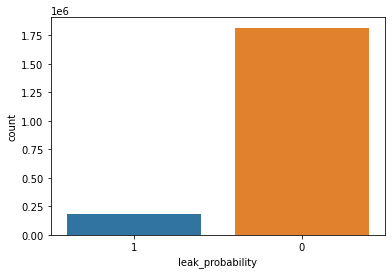

In [223]:
# visualize the data
sns.countplot(detection_input['leak_probability'])
f = 0
t = 0
# calculate the time range of the dataset
min_time = int(detection_input['time'].min())
max_time = int(detection_input['time'].max())
time_range = max_time - min_time
for i in range(min_time, max_time, 1):
    if time_classification_map.get(i, False):
        f += 1
    else:
        t += 1
print('Time range: ', time_range)
print('Number of false: ', f)
print('Number of true: ', t)



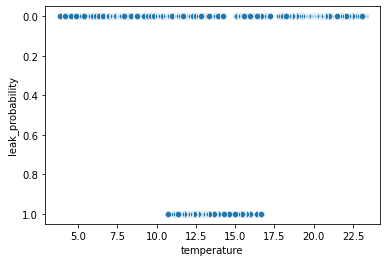

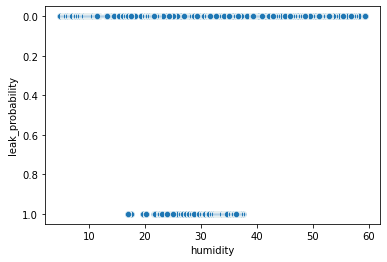

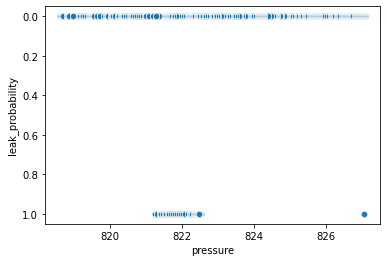

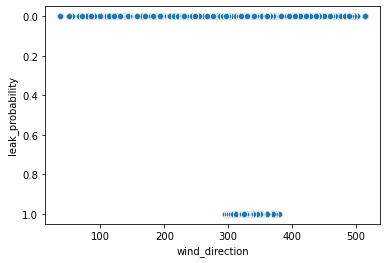

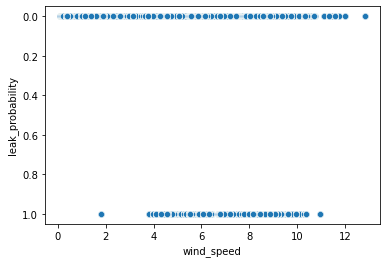

In [224]:
#visualize the weather and find correlations between weather and leak probability
sns.scatterplot(x='temperature', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='humidity', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='pressure', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='wind_direction', y='leak_probability', data=detection_input)
plt.show()
sns.scatterplot(x='wind_speed', y='leak_probability', data=detection_input)
plt.show()


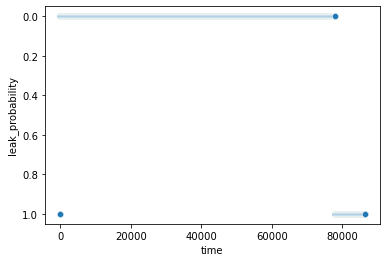

In [225]:
# visualize the correlation between the time and leak probability
sns.scatterplot(x='time', y='leak_probability', data=detection_input)
plt.show()

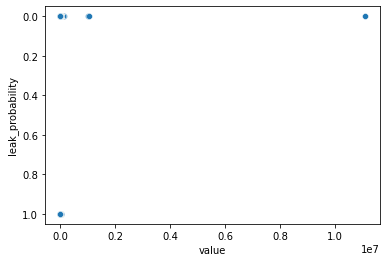

In [221]:
# visualize the coorelation between the values and leak probability
sns.scatterplot(x='value', y='leak_probability', data=detection_input)
plt.show()

In [226]:
# train a decision tree classifier on the data to see how well it can predict leak probability
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into training and testing sets
X = detection_input.drop(['leak_probability'], axis=1)
y = detection_input['leak_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# mak